In [222]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [223]:
# read in training data
X_train = np.load('../proj1/data/X_train.npy', allow_pickle=True)
Y_train = np.load('../proj1/data/Y_train.npy', allow_pickle=True)
Y_train = Y_train.astype(int)

In [224]:
# select out only the 0s or 1s
X_train_0 = X_train[Y_train == 0]
X_train_1 = X_train[Y_train == 1]
# combine
X_train_01 = np.concatenate((X_train_0, X_train_1)) / 256 # normalize
Y_train_01 = np.concatenate((np.zeros(X_train_0.shape[0]), np.ones(X_train_1.shape[0])))

## logistic regression

In [225]:
def sigmoid(z):
    # Clip z to prevent overflow in exp, -709 <= z <= 709
    z = np.clip(z, -709, 709)
    return 1 / (1 + np.exp(-z))

def logistic_loss(weights, X, y_true, lambda_):
    predictions = sigmoid(X @ weights)
    # Add a small epsilon to prevent log(0)
    epsilon = 1e-10
    loss = -np.sum(y_true * np.log(predictions + epsilon) + 
                   (1 - y_true) * np.log(1 - predictions + epsilon)) / X.shape[0]
    # Regularization (excluding the bias term if it's included)
    reg_term = lambda_ * np.sum(weights[1:] ** 2)
    return loss + reg_term

def gradient(X, y, w, lambda_):
    predictions = sigmoid(X @ w)
    error = predictions - y
    grad = X.T @ error / X.shape[0]
    # Regularization gradient (excluding the bias term if it's included)
    reg_grad = np.hstack(([0], lambda_ * 2 * w[1:]))
    return grad + reg_grad

def hessian(X, w, lambda_):
    predictions = sigmoid(X @ w)
    S = np.diag(predictions * (1 - predictions))
    H = X.T @ S @ X / X.shape[0]
    # Add regularization to the Hessian (excluding the bias term if it's included)
    reg_H = np.eye(len(w)) * lambda_ * 2
    reg_H[0, 0] = 0  # Do not regularize the bias term
    return H + reg_H

def gradient_descent(X, y, w_init, lambda_, lr=0.01, tol=1e-5, max_iter=100):
    w = w_init
    losses = []

    for i in range(max_iter):
        grad = gradient(X, y, w, lambda_)
        w_new = w - lr * grad
        loss = logistic_loss(w_new, X, y, lambda_)
        losses.append(loss)

        # Check for convergence
        if np.linalg.norm(grad) < tol:
            break
        w = w_new

    return w, losses

def newtons_method(X, y, w_init, lambda_, tol=1e-5, max_iter=100):
    w = w_init
    losses = []

    for i in range(max_iter):
        grad = gradient(X, y, w, lambda_)
        H = hessian(X, w, lambda_)
        w_new = w - np.linalg.pinv(H) @ grad
        loss = logistic_loss(w_new, X, y, lambda_)
        losses.append(loss)

        # Check for convergence
        if np.linalg.norm(grad) < tol:
            break
        w = w_new

    return w, losses


In [226]:
# run both on the objective funcs
newton_x, newton_losses = newtons_method(y=Y_train_01, X=X_train_01, w_init=np.zeros((X_train_01.shape[1])), lambda_=0.05)


KeyboardInterrupt: 

In [ ]:
newton_losses[-1]

0.10377001801545029

In [ ]:
grad_x, grad_losses = gradient_descent(y=Y_train_01, X=X_train_01, w_init=np.zeros(X_train_01.shape[1]),lambda_=0.05)

In [ ]:
grad_losses[-1]

0.1509291227172239

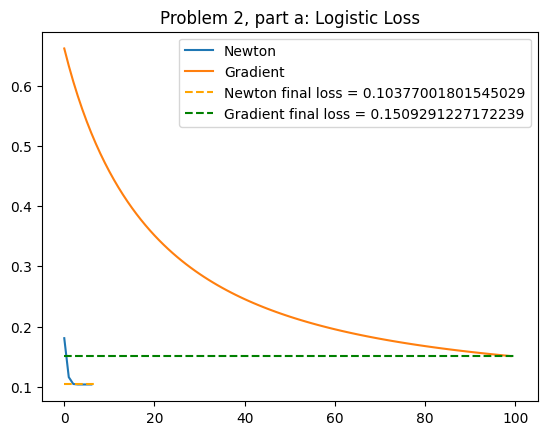

In [ ]:
# plot the losses
plt.plot(newton_losses, label='Newton')
plt.plot(grad_losses, label='Gradient')
plt.hlines(newton_losses[-1], 0, len(newton_losses), linestyles='dashed', label=f'Newton final loss = {newton_losses[-1]}', color='orange')
plt.hlines(grad_losses[-1], 0, len(grad_losses), linestyles='dashed', label=f'Gradient final loss = {grad_losses[-1]}', color='green')
plt.legend()
plt.title('Problem 2, part a: Logistic Loss')
plt.savefig('p2a.png')

In [ ]:
# calculate accuracy, precision, recall, and F1 score
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp)

def recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn)

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p + r)

In [ ]:
accuracy(Y_train_01, (sigmoid(X_train_01 @ newton_x) > 0.5).astype(int))

0.9971626733921816

In [ ]:
# use test data
X_test = np.load('../proj1/data/X_test.npy', allow_pickle=True)
Y_test = np.load('../proj1/data/Y_test.npy', allow_pickle=True)
Y_test = Y_test.astype(int)

# select out only the 0s or 1s
X_test_0 = X_test[Y_test == 0]
X_test_1 = X_test[Y_test == 1]
# combine
X_test_01 = np.concatenate((X_test_0, X_test_1)) / 256 # normalize
Y_test_01 = np.concatenate((np.zeros(X_test_0.shape[0]), np.ones(X_test_1.shape[0])))

In [ ]:
# predict
newton_acc = accuracy(Y_test_01, sigmoid(X_test_01 @ newton_x) > 0.5)
newton_prec = precision(Y_test_01, sigmoid(X_test_01 @ newton_x) > 0.5)
newton_rec = recall(Y_test_01, sigmoid(X_test_01 @ newton_x) > 0.5)
newton_f1 = f1_score(Y_test_01, sigmoid(X_test_01 @ newton_x) > 0.5)
print('Newton')
print(newton_acc)
print(newton_prec)
print(newton_rec)
print(newton_f1)

grad_acc = accuracy(Y_test_01, sigmoid(X_test_01 @ grad_x) > 0.5)
grad_prec = precision(Y_test_01, sigmoid(X_test_01 @ grad_x) > 0.5)
grad_rec = recall(Y_test_01, sigmoid(X_test_01 @ grad_x) > 0.5)
grad_f1 = f1_score(Y_test_01, sigmoid(X_test_01 @ grad_x) > 0.5)
print('Gradient')
print(grad_acc)
print(grad_prec)
print(grad_rec)
print(grad_f1)


Newton
0.9986403806934059
0.9974570883661793
1.0
0.9987269255251432
Gradient
0.9976206662134602
0.9961880559085133
0.9993626513702996
0.997772828507795


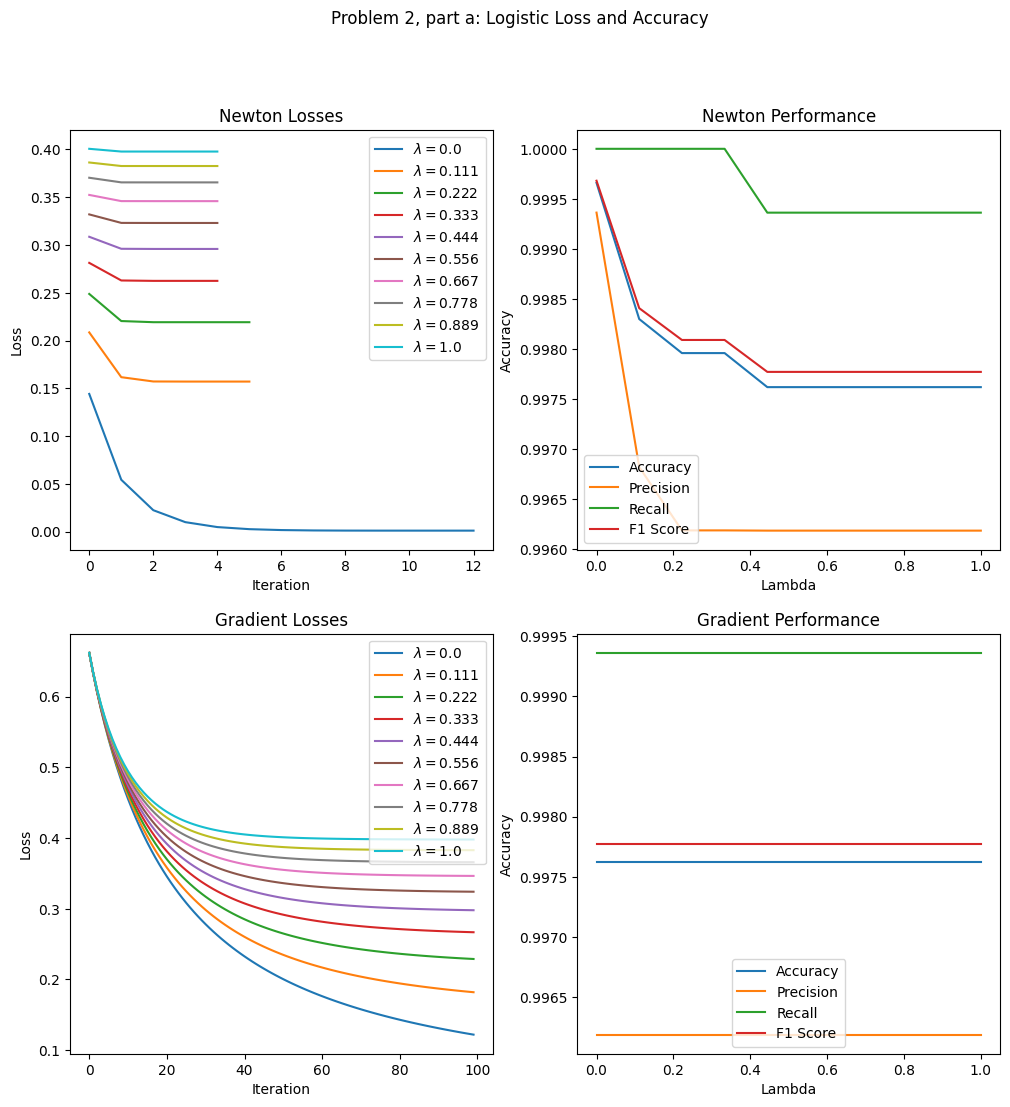

max newton acc 0.9996600951733514
max newton lambda 1e-05
max grad acc 0.9976206662134602
max grad lambda 1e-05


In [ ]:
# try 10 different lambdas and plot the results
lambdas = np.linspace(1e-5, 1, 10)
accs = []
precs = []
recs = []
f1s = []

accs_grad = []
precs_grad = []
recs_grad = []
f1s_grad = []

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0,0].set_title('Newton Losses')
ax[0,0].set_xlabel('Iteration')
ax[0,0].set_ylabel('Loss')
ax[0,1].set_title('Newton Performance')
ax[0,1].set_xlabel('Lambda')
ax[0,1].set_ylabel('Accuracy')
ax[1,0].set_title('Gradient Losses')
ax[1,0].set_xlabel('Iteration')
ax[1,0].set_ylabel('Loss')
ax[1,1].set_title('Gradient Performance')
ax[1,1].set_xlabel('Lambda')
ax[1,1].set_ylabel('Accuracy')

for lambda_ in lambdas:
    x, newton_losses = newtons_method(y=Y_train_01, X=X_train_01, w_init=np.zeros(X_train_01.shape[1]),lambda_=lambda_)
    accs.append(accuracy(Y_test_01, sigmoid(X_test_01 @ x) > 0.5))
    precs.append(precision(Y_test_01, sigmoid(X_test_01 @ x) > 0.5))
    recs.append(recall(Y_test_01, sigmoid(X_test_01 @ x) > 0.5))
    f1s.append(f1_score(Y_test_01, sigmoid(X_test_01 @ x) > 0.5))

    x, grad_losses = gradient_descent(y=Y_train_01, X=X_train_01, w_init=np.zeros(X_train_01.shape[1]),lambda_=lambda_)
    accs_grad.append(accuracy(Y_test_01, sigmoid(X_test_01 @ x) > 0.5))
    precs_grad.append(precision(Y_test_01, sigmoid(X_test_01 @ x) > 0.5))
    recs_grad.append(recall(Y_test_01, sigmoid(X_test_01 @ x) > 0.5))
    f1s_grad.append(f1_score(Y_test_01, sigmoid(X_test_01 @ x) > 0.5))

    lambda_ = round(lambda_, 3)

    ax[0,0].plot(newton_losses, label=f'$\lambda = {lambda_}$')
    ax[1,0].plot(grad_losses, label=f'$\lambda = {lambda_}$')

ax[0,1].plot(lambdas, accs, label='Accuracy')
ax[0,1].plot(lambdas, precs, label='Precision')
ax[0,1].plot(lambdas, recs, label='Recall')
ax[0,1].plot(lambdas, f1s, label='F1 Score')
ax[1,1].plot(lambdas, accs_grad, label='Accuracy')
ax[1,1].plot(lambdas, precs_grad, label='Precision')
ax[1,1].plot(lambdas, recs_grad, label='Recall')
ax[1,1].plot(lambdas, f1s_grad, label='F1 Score')

ax[0,0].legend()
ax[1,0].legend()
ax[0,1].legend()
ax[1,1].legend()
fig.suptitle('Problem 2, part a: Logistic Loss and Accuracy')

plt.savefig('p2a_full.png')
plt.show()

# find maximum accuracy and corresponding lambda
max_acc = max(accs)
max_acc_lambda = lambdas[accs.index(max_acc)]
print('max newton acc', max_acc)
print('max newton lambda', max_acc_lambda)

# again for gradient descent
max_acc_grad = max(accs_grad)
max_acc_lambda_grad = lambdas[accs_grad.index(max_acc_grad)]
print('max grad acc', max_acc_grad)
print('max grad lambda', max_acc_lambda_grad)

## softmax regression

In [267]:
def softmax(z):
    """
    Numerically stable softmax.
    """
    z_max = np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z-z_max)
    prob = exp_z / exp_z.sum(axis=1).reshape(-1, 1)
    return prob

def cross_entropy_loss(y_true, y_pred):
    """
    Stable cross-entropy loss.
    """
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    ce_loss = -np.sum(y_true * np.log(y_pred)) 
    return ce_loss

def gradient_softmax(X, y, w, lambda_):
    """
    Gradient of the softmax regression loss with L2 regularization.
    """
    y_hat = softmax(X @ w)
    error = y_hat - y
    grad = X.T @ error 
    reg_grad = lambda_ * w
    return grad + reg_grad

def gradient_descent_softmax(X, y, lambda_, w0, lr=0.00001, tol=1e-5, max_iter=100):
    """
    Gradient descent for softmax regression.
    """
    w = w0
    losses = []

    for i in range(max_iter):
        y_hat = softmax(X @ w)
        loss = cross_entropy_loss(y, y_hat) + lambda_ * np.diag(w.T @ w).sum()
        # print(loss)
        losses.append(loss)

        grad = gradient_softmax(X, y, w, lambda_)
        w_new = w - lr * grad

        # Check for convergence based on the change in weights
        if np.linalg.norm(w_new - w, ord=1) < tol:
            break

        w = w_new

    return w, losses


In [233]:
# one-hot encode the labels
Y_train_onehot = np.eye(10)[Y_train.astype(int)]
Y_test_onehot = np.eye(10)[Y_test.astype(int)]

In [256]:
grad_x, grad_losses = gradient_descent_softmax(y=Y_train_onehot, X=X_train, w0=np.zeros((X_train.shape[1], 10)), lambda_=0.01)

2.3025850929940437
1.7242295891338588
1.3945539463724592
1.2007788400665484
1.0929880196439217
1.0031029253419945
0.9768261964694621
0.8583141350150033
0.83491172475316
0.7807940792687456
0.7653652987769789
0.7184333775336336
0.6991632287264242
0.6674389105662356
0.6475957580101053
0.6251688371931926
0.6078564380030099
0.5917797504781019
0.5782757718722676
0.5665284089321997
0.5563210834106345
0.547370775629241
0.5393752711777899
0.5321496634180916
0.525524298289292
0.5193911466354901
0.5136687984149177
0.5083008774013349
0.5032453728130826
0.49846990991838974
0.493948220143743
0.48965815902481463
0.485580556097296
0.4816985341854565
0.4779970829839506
0.47446276652193126
0.471083503193882
0.46784839115931054
0.4647475630629468
0.4617720634798805
0.45891374376715754
0.45616517154961195
0.4535195522351921
0.4509706607910738
0.44851278217775453
0.4461406591996829
0.44384944669517923
0.4416346711837072
0.43949219521794036
0.4374181858093143
0.43540908638933057
0.43346159184983285
0.431572

In [257]:
y_pred = np.argmax(softmax(X_test @ grad_x), axis=1)

In [258]:
y_pred

array([1, 5, 5, ..., 4, 5, 6], dtype=int64)

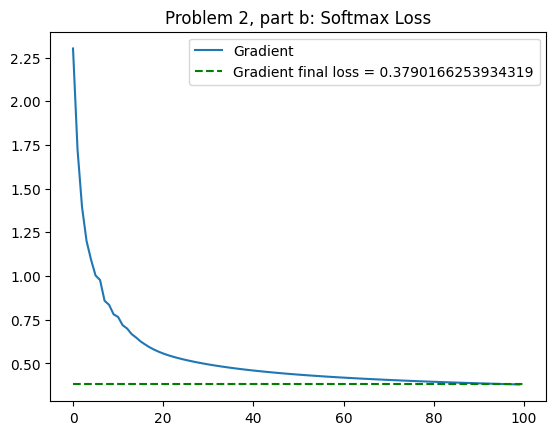

In [259]:
plt.plot(grad_losses, label='Gradient')
plt.hlines(grad_losses[-1], 0, len(grad_losses), linestyles='dashed', label=f'Gradient final loss = {grad_losses[-1]}', color='green')
plt.legend()
plt.title('Problem 2, part b: Softmax Loss')
plt.savefig('p2b.png')

In [260]:
# caluclate accuracy
accuracy(Y_test, y_pred)

0.9091428571428571

1e-05 0.916
0.11112 0.9112857142857143
0.22223 0.7432857142857143
0.33334 0.7317857142857143
0.44445 0.913
0.5555599999999999 0.9139285714285714
0.66667 0.9134285714285715
0.7777799999999999 0.8967142857142857
0.88889 0.7912142857142858
1.0 0.9156428571428571


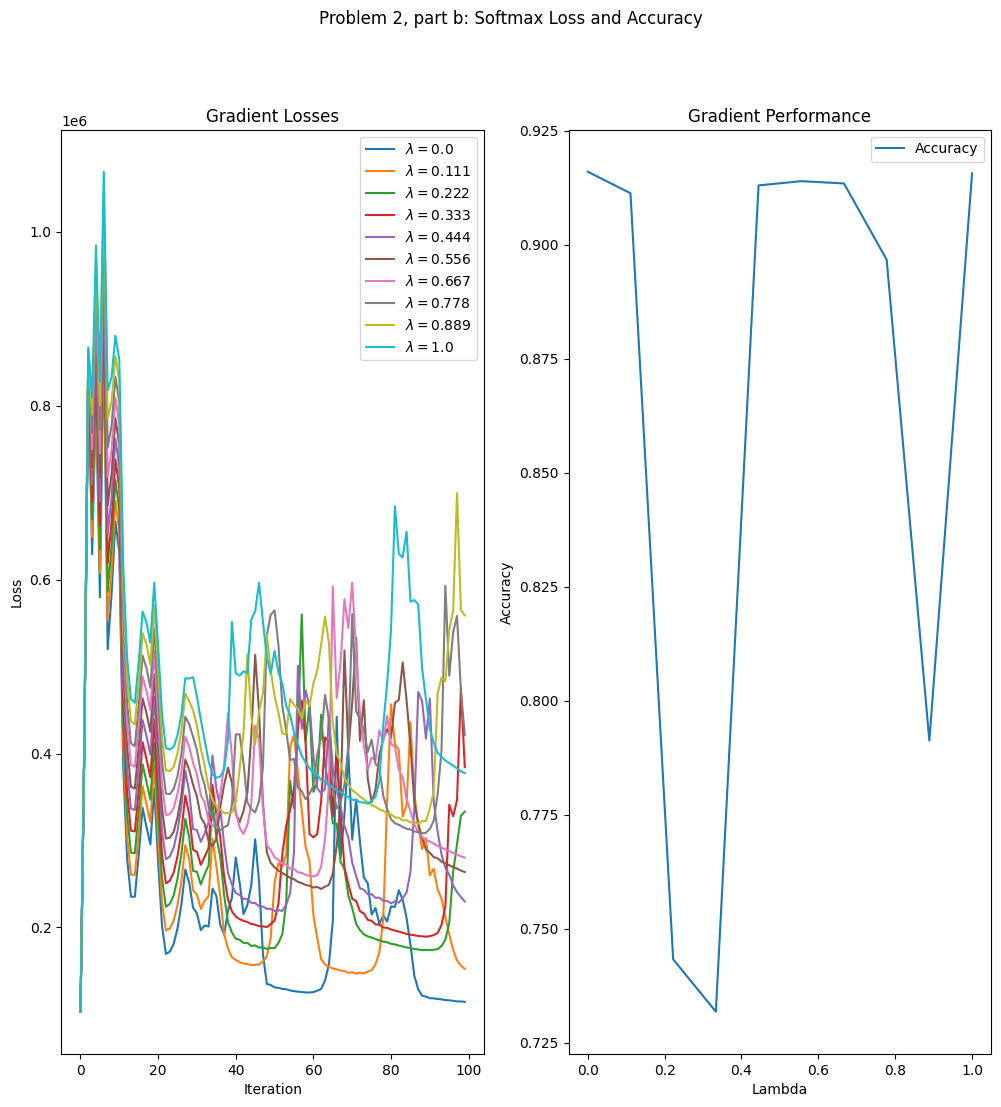

In [268]:
# do for 10 different lambdas
lambdas = np.linspace(1e-5, 1, 10)
accs = []

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].set_title('Gradient Losses')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[1].set_title('Gradient Performance')
ax[1].set_xlabel('Lambda')
ax[1].set_ylabel('Accuracy')

for lambda_ in lambdas:
    x, grad_losses = gradient_descent_softmax(y=Y_train_onehot, X=X_train, w0=np.zeros((X_train.shape[1], 10)), lambda_=lambda_)
    # compare predict to true
    y_pred = softmax(X_test @ x)
    # take dot product of y_pred and y_true and divide by length
    accs.append(np.sum(np.argmax(y_pred, axis=1) == Y_test) / len(Y_test))
    print(lambda_, accs[-1])

    lambda_ = round(lambda_, 3)
    ax[0].plot(grad_losses, label=f'$\lambda = {lambda_}$')

ax[1].plot(lambdas, accs, label='Accuracy')
ax[0].legend()
ax[1].legend()
fig.suptitle('Problem 2, part b: Softmax Loss and Accuracy')

plt.savefig('p2b_full.png')
plt.show()

In [ ]:
grad_losses

[193541373.22162545, 214643666.0924555, 4239.371651554036, 0.0]

In [ ]:
np.nonzero(x)

(array([ 12,  12,  13, ..., 778, 778, 779], dtype=int64),
 array([2, 6, 2, ..., 7, 9, 7], dtype=int64))

In [ ]:
y_pred[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
Y_test

array([1, 8, 5, ..., 4, 5, 6])